# Library import

In [ ]:
!pip install yfinance==0.2.40
!pip install japanize_matplotlib
import math
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
%matplotlib inline
plt.style.use("ggplot")
import japanize_matplotlib

from pandas_datareader import data as wb
import yfinance as yfin
yfin.pdr_override()

# Get and Setting Data

[*********************100%%**********************]  1 of 1 completed


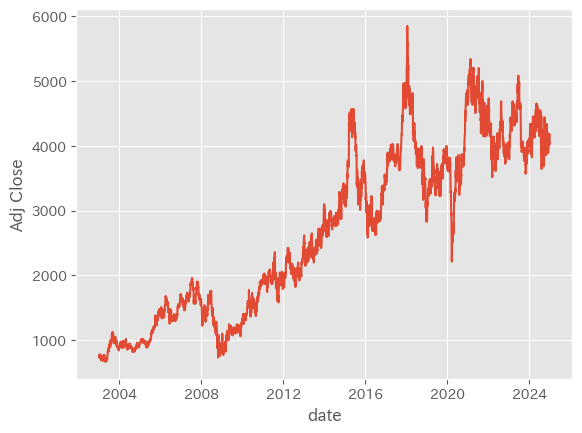

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5467 entries, 2003-01-01 to 2024-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5467 non-null   float64
 1   High       5467 non-null   float64
 2   Low        5467 non-null   float64
 3   Close      5467 non-null   float64
 4   Adj Close  5467 non-null   float64
 5   Volume     5467 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 299.0 KB


In [ ]:
# Parameter for data
## Security code
stock_code='6954.T' #FANUC:6954.T
## Start Date
start_date='2003-1-1'
## End Date
end_date='2024-12-31'
## Split ratio of train data and validation data
train_rate=0.7
# Split ratio of validation data and test data
valid_rate=0.15
## How many business days to see
observation_period_num=60
## How many business days to predict
predict_period_num=5

# Parameter for mdoel
## Learning Rate
lr=0.00005# 0.00005
## Epoch Number
epochs=1000
## Mini-Batch size
batch_size=16#16
#the numer of transforemer layers
num_tran_layers = 7
## How many epochs to stop train if valid loss is not decreasing
patience=20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get data
df=wb.DataReader(stock_code,start=start_date,end=end_date)

# Plot 'Adj Close' values
plt.plot(df.iloc[:,-2])
plt.xlabel('date')
plt.ylabel('Adj Close')
plt.show()

df.info()

<Axes: xlabel='Date'>

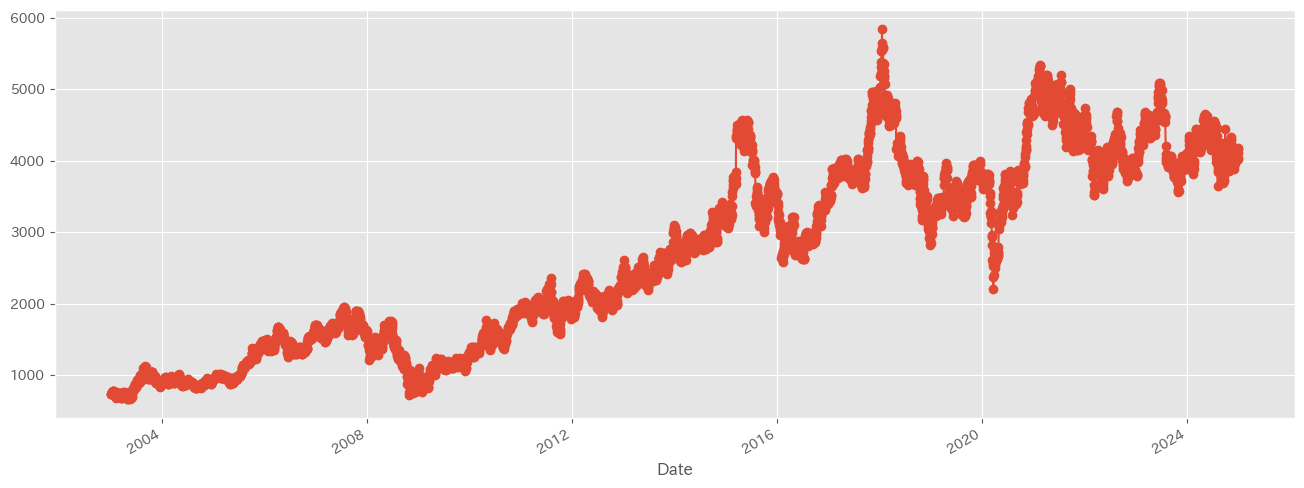

In [ ]:
df["Adj Close"].plot(figsize=(16,6), marker = "o")

In [ ]:
# Normalization
mean_list=df.mean().values
std_list=df.std().values
df=(df-mean_list)/std_list
df

#inverse
def inverse_normalization(data):
    return data*std_list[4]+mean_list[4]

In [ ]:
df.index[-5:]

DatetimeIndex(['2024-12-24', '2024-12-25', '2024-12-26', '2024-12-27',
               '2024-12-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
# Array initialization
inout_data=[]

# Put data in array
for i in range(len(df)-observation_period_num-predict_period_num):
  data=df.iloc[i:i+observation_period_num,4].values # input x = (x_i, ... , x_{i + observation_num})
  label=df.iloc[i+predict_period_num:i+observation_period_num+predict_period_num,4].values # label y = ( x_{i+predict_period_num}, ... , x_{i + observation_period_num + predict_period_num} )
  inout_data.append((data,label))
inout_data=torch.FloatTensor(inout_data)

train_data=inout_data[:int(np.shape(inout_data)[0]*train_rate)].to(device)
valid_data=inout_data[int(np.shape(inout_data)[0]*train_rate):int(np.shape(inout_data)[0]*(train_rate+valid_rate))].to(device)
test_data =inout_data[int(np.shape(inout_data)[0]*(train_rate+valid_rate)):].to(device)

print('train data：',np.shape(train_data)[0])
print('valid data：',np.shape(valid_data)[0])
print('test data：',np.shape(test_data)[0])

train data： 3781
valid data： 810
test data： 811


# Model Definition

In [ ]:
# Define a function for getting mini-batch
def get_batch(source, i, batch_size):
    seq_len=min(batch_size, len(source)-1-i)
    data=source[i:i+seq_len]
    input=torch.stack(torch.stack([item[0] for item in data]).chunk(observation_period_num,1))
    target=torch.stack(torch.stack([item[1] for item in data]).chunk(observation_period_num,1))

    return input, target


# Functions for positional encoding
class PositionalEncoding(nn.Module):
  def __init__(self,d_model,max_len=5000):
    super().__init__()
    self.dropout=nn.Dropout(p=0.1)
    pe=torch.zeros(max_len, d_model)
    position=torch.arange(0, max_len,dtype=torch.float).unsqueeze(1)
    div_term=torch.exp(torch.arange(0,d_model, 2).float()*(-math.log(10000.0)/d_model))
    pe[:,0::2]=torch.sin(position*div_term)
    pe[:,1::2]=torch.cos(position*div_term)
    pe=pe.unsqueeze(0).transpose(0,1)
    self.register_buffer("pe",pe)

  def forward(self,x):
    return self.dropout(x+self.pe[:np.shape(x)[0],:])


# Transformer model definition
class TransformerModel(nn.Module):
  def __init__(self,feature_size=250,num_layers=num_tran_layers,dropout=0.1):
    super().__init__()
    self.model_type='Transformer'
    self.src_mask=None
    self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.pos_encoder=PositionalEncoding(d_model=feature_size)

    self.encoder_layer=nn.TransformerEncoderLayer(d_model=feature_size,nhead=10,dropout=dropout)
    self.transformer_encoder=nn.TransformerEncoder(self.encoder_layer,num_layers=num_layers)

    self.decoder=nn.Linear(feature_size,1)

  def init_weights(self):
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform(-0.1,0.1)

  def _generate_square_subsequent_mask(self,sz):
    mask=(torch.triu(torch.ones(sz,sz))==1).transpose(0,1)
    mask=mask.float().masked_fill(mask==0,float('-inf')).masked_fill(mask==1,float(0.0))
    return mask

  def forward(self,src):
    if self.src_mask is None or self.src_mask.size(0)!=len(src):
      device=self.device
      mask=self._generate_square_subsequent_mask(len(src)).to(device)
      self.src_mask=mask
    src=self.pos_encoder(src)
    output=self.transformer_encoder(src,self.src_mask)
    output=self.decoder(output)
    return output


# Function for early stop of train if valid loss is not decreasing
class EarlyStopping:
    def __init__(self,patience=5):
        self.patience=patience
        self.counter=0
        self.best_score=None
        self.early_stop=False
        self.val_loss_min=np.Inf

    def __call__(self,val_loss,model):
        score=(-val_loss)
        if self.best_score is None:
            self.best_score=score
        elif score<self.best_score:
            self.counter+=1
            if self.counter>=self.patience:
                self.early_stop=True
        else:
            self.best_score=score
            self.counter=0

# Train

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


 10:epoch | 0.02467952 : train loss | 0.2299485 : valid loss
 20:epoch | 0.04107395 : train loss | 0.6768433 : valid loss
 28:epoch | 0.04572505 : train loss | 1.306697 : valid loss
Early Stop


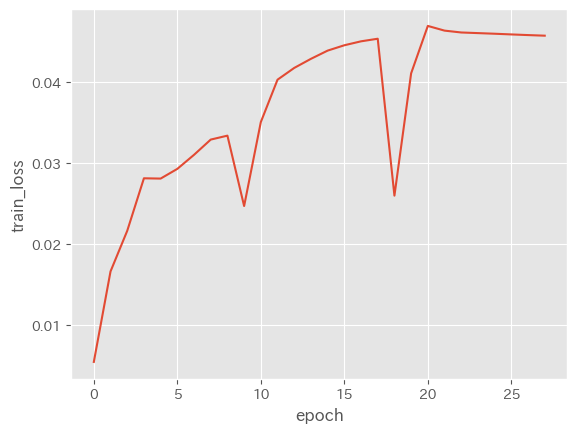

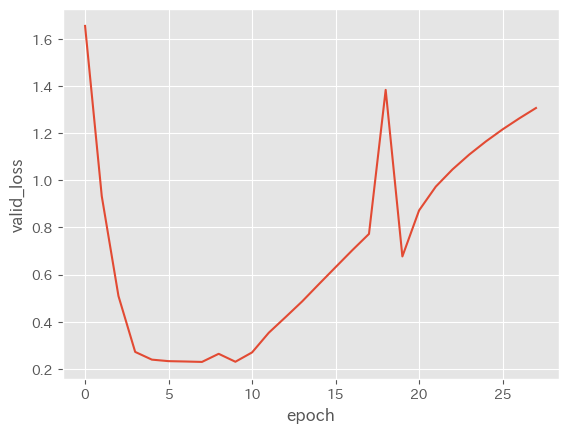

In [ ]:
model=TransformerModel().to(device)
criterion=nn.MSELoss()

optimizer=torch.optim.AdamW(model.parameters(),lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,1.0,gamma=0.95)
earlystopping=EarlyStopping(patience)

train_loss_list=[]
valid_loss_list=[]

for epoch in range(1,epochs+1):
  # train
  model.train()
  total_loss_train=0.0
  for batch, i in enumerate(range(0,len(train_data),batch_size)):
    data,targets=get_batch(train_data,i,batch_size)
    optimizer.zero_grad()
    output=model(data)
    loss=criterion(output,targets)
    loss.backward()
    optimizer.step()
    total_loss_train+=loss.item()
  scheduler.step()
  total_loss_train=total_loss_train/len(train_data)

  #valid
  model.eval()
  total_loss_valid=0.0
  for i in range(0,len(valid_data),batch_size):
    data,targets=get_batch(valid_data,i,batch_size)
    output=model(data)
    total_loss_valid+=len(data[0])*criterion(output, targets).cpu().item()
  total_loss_valid=total_loss_valid/len(valid_data)

  #etc
  train_loss_list.append(total_loss_train)
  valid_loss_list.append(total_loss_valid)
  if epoch%10==0:
    print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
  earlystopping((total_loss_valid),model)
  if earlystopping.early_stop:
    print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
    print("Early Stop")
    break

plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.plot(train_loss_list)
plt.show()

plt.xlabel('epoch')
plt.ylabel('valid_loss')
plt.plot(valid_loss_list)
plt.show()

# Test

In [ ]:
test_data.shape

torch.Size([811, 2, 60])

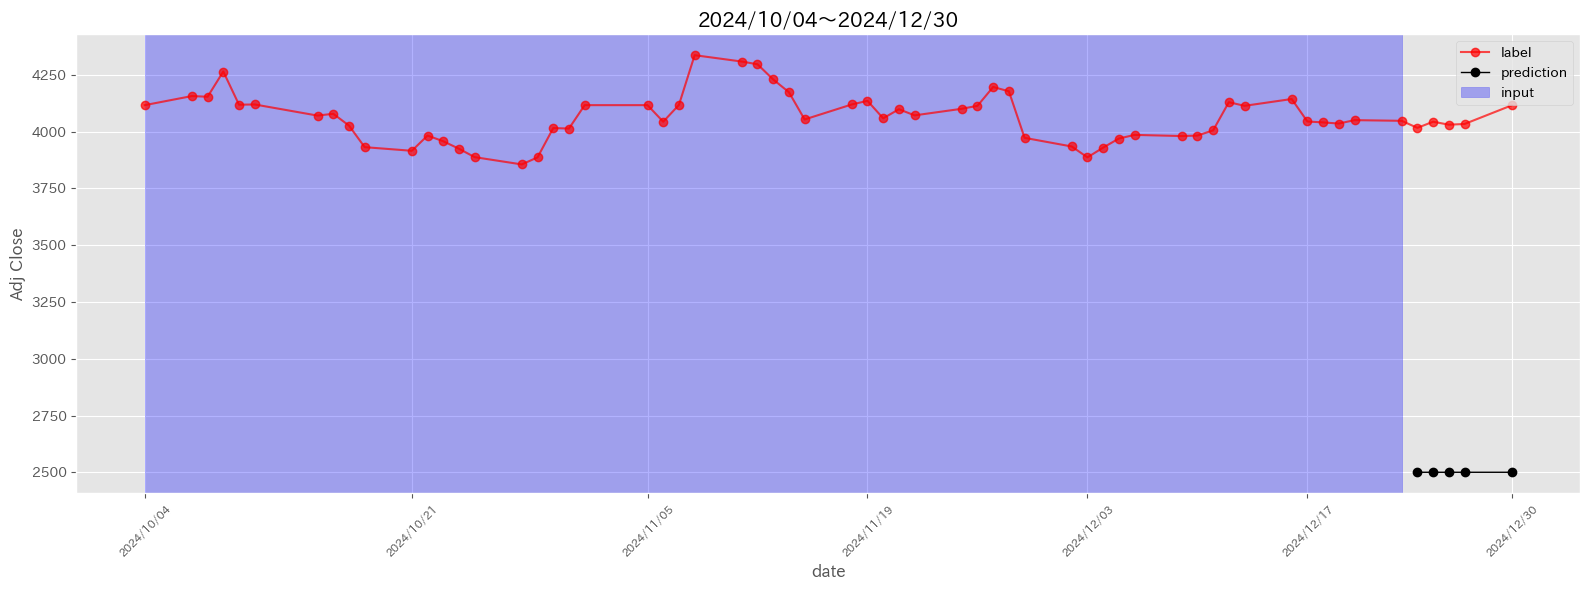

Mean Absolute Error (MAE): 1.1795425415039062
Root Mean Squared Error (RMSE): 1.1798419952392578


In [ ]:
model.eval()
prediction=torch.Tensor(0)
actual=torch.Tensor(0)

#In TDE contex, data = X[-2], target= X[-1]
with torch.no_grad():
  data, target = get_batch(test_data, len(test_data)-2, 1) # モデルに入れる際にはテンソル化処理等が必要であるため, batchsize=1で処理　(バッチ分割はしていないということ)
  output = model(data) #prediction
  prediction=torch.cat((prediction, output.view(-1).cpu()),0)
  actual=torch.cat((actual,target.view(-1).cpu()),0)

date = df.index[-60:] #for date label
#actual = inverse_normalization( target.view(-1).cpu() )
#prediction = inverse_normalization( prediction.view(-1).detach().cpu() )

#plot
plt.figure(figsize=(16, 6))
plt.plot(date,inverse_normalization( target.view(-1).cpu() ) ,color='red',label = "label",alpha=0.7, marker="o")
plt.plot(date[-5:],inverse_normalization( prediction.view(-1).detach().cpu()[-5:] ),color='black',label = "prediction",linewidth=1.0, marker="o")
plt.axvspan(date[0],date[-6], color='blue', alpha=0.3, label='input')

plt.legend()

plt.xlabel('date')
plt.ylabel('Adj Close')

# x軸メモリの設定
begin_date = date[0]
end_date = date[-1]
ticks = list(date[::10])  # 10日ごとの目盛
ticks.insert(0, begin_date)  # 最初の日付を追加
ticks.append(end_date)    # 最後の日付を追加
ticks = sorted(set(ticks))  # 重複を除きソート

plt.title(f"{begin_date.strftime('%Y/%m/%d')}～{end_date.strftime('%Y/%m/%d')}")

# x軸メモリを設定
plt.xticks(ticks, [t.strftime('%Y/%m/%d') for t in ticks], rotation=45, fontsize=8)

# プロット表示
plt.tight_layout()  # レイアウト調整
plt.show()

# EVAL
# MAEの計算
mae = torch.mean(torch.abs(prediction[-5:] - actual[-5:])).item()
print(f"Mean Absolute Error (MAE): {mae}")
# RMSEの計算
rmse = torch.sqrt(torch.mean((prediction[-5:] - actual[-5:]) ** 2)).item()
print(f"Root Mean Squared Error (RMSE): {rmse}")

In [ ]:
# EVAL
# MAEの計算
mae = torch.mean(torch.abs(inverse_normalization(prediction[-5:]) - inverse_normalization(actual[-5:]))).item()
print(f"Mean Absolute Error (MAE): {mae}")
# RMSEの計算
rmse = torch.sqrt(torch.mean((inverse_normalization(prediction[-5:]) - inverse_normalization(actual[-5:])) ** 2)).item()
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 1547.99853515625
Root Mean Squared Error (RMSE): 1548.3916015625


In [ ]:
# MAPEの計算
mape = torch.mean(torch.abs((inverse_normalization(prediction[-5:]) - inverse_normalization(actual[-5:])) / inverse_normalization(actual[-5:]))) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape.item()}%")


Mean Absolute Percentage Error (MAPE): 38.23275375366211%


In [ ]:
"""# X(input), Y(label)のイメージ slide code
#plot
date=df.index[-65:]

plt.figure(figsize=(12, 6))
plt.plot(date[:-5],  data.cpu().numpy().flatten(),color='red',label = "input",alpha=0.7, marker="o", markersize=10)
plt.plot(date[5:], target.cpu().numpy().flatten(),color='black',label = "label(5-day future)",linewidth=1.0, marker="*")
plt.axvspan(date[-5],date[-1], color='blue', alpha=0.3, label='Prediction Period')
plt.legend()

plt.title(f"{begin_date.strftime('%Y/%m/%d')}～{end_date.strftime('%Y/%m/%d')}")

# x軸メモリの設定
begin_date = date[0]
end_date = date[-1]
ticks = list(date[::10])  # 10日ごとの目盛
ticks.insert(0, begin_date)  # 最初の日付を追加
ticks.append(end_date)    # 最後の日付を追加
ticks = sorted(set(ticks))  # 重複を除きソート

# x軸メモリを設定
plt.xticks(ticks, [t.strftime('%Y/%m/%d') for t in ticks], rotation=45, fontsize=8)

# プロット表示
plt.tight_layout()  # レイアウト調整

plt.xlabel('date')
plt.ylabel('Adj Close')"""

'# X(input), Y(label)のイメージ slide code\n#plot\ndate=df.index[-65:]\n\nplt.figure(figsize=(12, 6))\nplt.plot(date[:-5],  data.cpu().numpy().flatten(),color=\'red\',label = "input",alpha=0.7, marker="o", markersize=10)\nplt.plot(date[5:], target.cpu().numpy().flatten(),color=\'black\',label = "label(5-day future)",linewidth=1.0, marker="*")\nplt.axvspan(date[-5],date[-1], color=\'blue\', alpha=0.3, label=\'Prediction Period\')\nplt.legend()\n\nplt.title(f"{begin_date.strftime(\'%Y/%m/%d\')}～{end_date.strftime(\'%Y/%m/%d\')}")\n\n# x軸メモリの設定\nbegin_date = date[0]\nend_date = date[-1]\nticks = list(date[::10])  # 10日ごとの目盛\nticks.insert(0, begin_date)  # 最初の日付を追加\nticks.append(end_date)    # 最後の日付を追加\nticks = sorted(set(ticks))  # 重複を除きソート\n\n# x軸メモリを設定\nplt.xticks(ticks, [t.strftime(\'%Y/%m/%d\') for t in ticks], rotation=45, fontsize=8)\n\n# プロット表示\nplt.tight_layout()  # レイアウト調整\n\nplt.xlabel(\'date\')\nplt.ylabel(\'Adj Close\')'

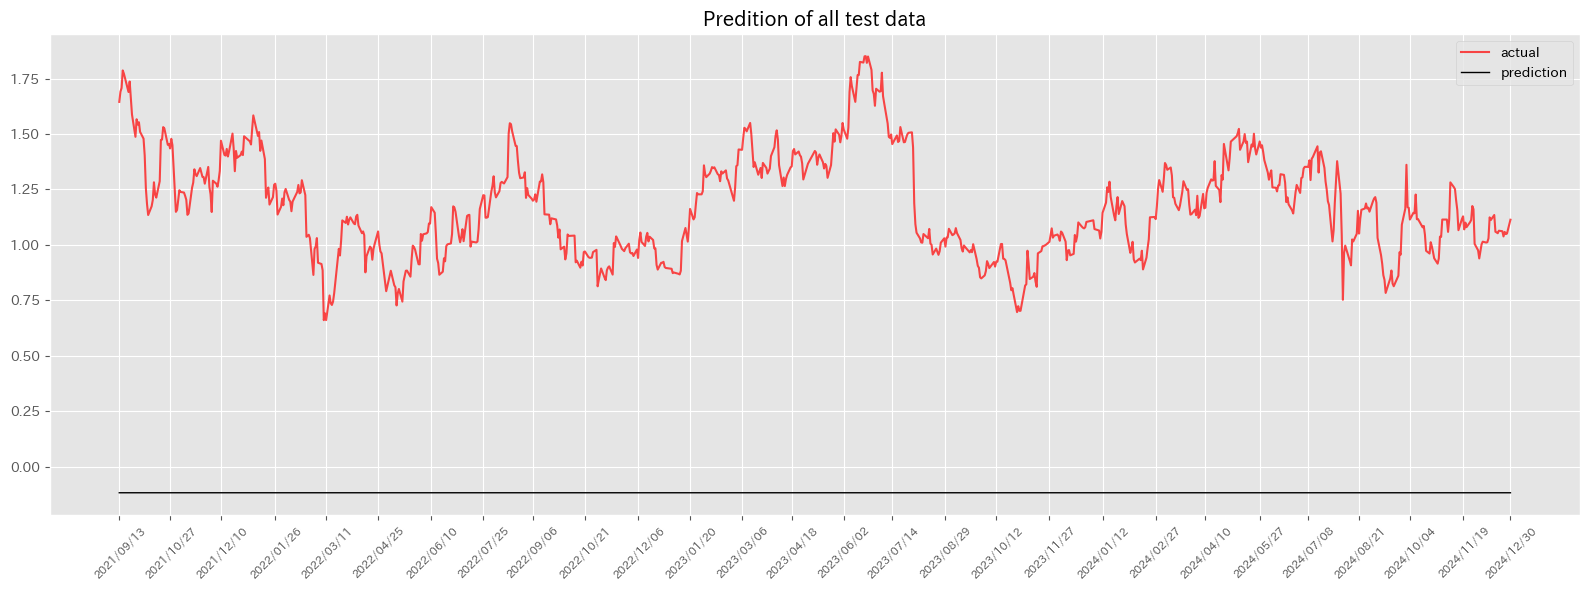

Mean Absolute Error (MAE): 1.2920308113098145
Root Mean Squared Error (RMSE): 1.3117042779922485


In [ ]:
model.eval()
result=torch.Tensor(0)
actual=torch.Tensor(0)

date = df.index[-(len(test_data)-1):]

mae_list = []
rmse_list = []

with torch.no_grad():
  for i in range(0,len(test_data)-1):
    data,target=get_batch(test_data,i,1) #batch size =1
    output=model(data)
    mae = torch.mean(torch.abs(output - target)).item()
    rmse = torch.sqrt(torch.mean((output - target) ** 2)).item()
    mae_list.append(mae)
    rmse_list.append(rmse)
    result=torch.cat((result, output[-1].view(-1).cpu()),0)
    actual=torch.cat((actual,target[-1].view(-1).cpu()),0)


plt.figure(figsize=(16, 6))
plt.plot(date, actual.cpu().numpy().flatten(), color='red',label="actual",alpha=0.7)
plt.plot(date,result.cpu().numpy().flatten(), color='black',linewidth=1.0, label = "prediction")
plt.legend()

# x軸メモリの設定
begin_date = date[0]
end_date = date[-1]
ticks = list(date[::30])
ticks.insert(0, begin_date)  # 最初の日付を追加
ticks.append(end_date)    # 最後の日付を追加
ticks = sorted(set(ticks))  # 重複を除きソート

# x軸メモリを設定
plt.xticks(ticks, [t.strftime('%Y/%m/%d') for t in ticks], rotation=45, fontsize=8)

plt.title("Predition of all test data")
plt.tight_layout()  # レイアウト調整
plt.show()

# EVAL
# MAEの計算
mae = torch.mean(torch.abs(result - actual)).item()
print(f"Mean Absolute Error (MAE): {mae}")
# RMSEの計算
rmse = torch.sqrt(torch.mean((result - actual) ** 2)).item()
print(f"Root Mean Squared Error (RMSE): {rmse}")

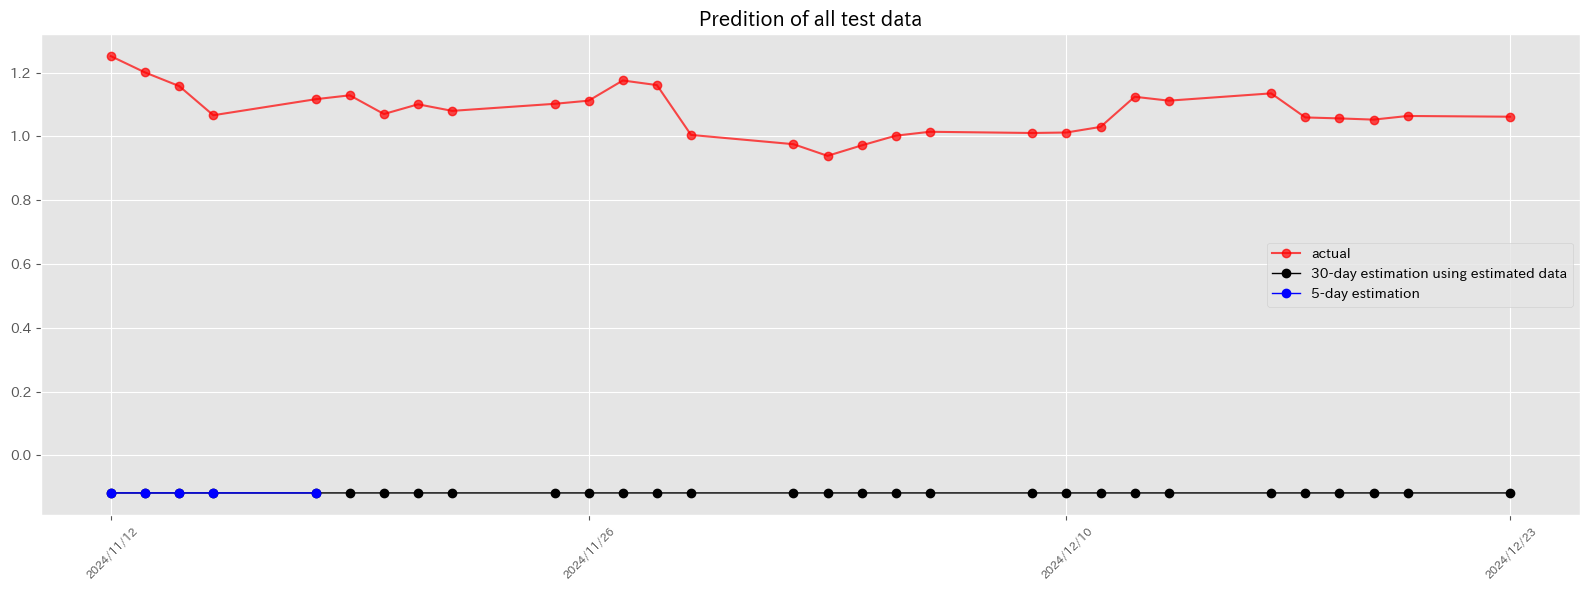

Mean Absolute Error (MAE): 1.1957801580429077
Root Mean Squared Error (RMSE): 1.1978704929351807


In [ ]:
# Forcast with estimated data
model.eval()
result=torch.Tensor(0)
actual=torch.Tensor(0)
date = []

date = df.index[-(len(test_data)-1):]

mae_list = []
rmse_list = []

est_range = 30

with torch.no_grad():
  #get first data
  data,target=get_batch(test_data,len(test_data)-(est_range + 2),1) #batch size =1

  for i in range(len(test_data)-(est_range+2), len(test_data)-2):
    _ ,target=get_batch(test_data,i,1) #batch size =1

    #output length = 60 days. 5 last days correspond to estimation. get fist est of 5 est.
    output=model(data)
    mae = torch.mean(torch.abs(output - target)).item()
    rmse = torch.sqrt(torch.mean((output - target) ** 2)).item()
    mae_list.append(mae)
    rmse_list.append(rmse)
    result=torch.cat((result, output[-5].view(-1).cpu()),0)
    actual=torch.cat((actual,target[-5].view(-1).cpu()),0)

    data = torch.cat((data[1:], output[-5:-4]), 0)
    #data = torch.cat((data[1:], output[-1:]), 0)

  _data,_target=get_batch(test_data,len(test_data)-(est_range + 2),1) #batch size =1
  _output=model(_data)



plt.figure(figsize=(16, 6))
plt.plot(date[-(est_range+5):-5], actual.cpu().numpy().flatten(), color='red',label="actual",alpha=0.7, marker="o")
plt.plot(date[-(est_range+5):-5],result.cpu().numpy().flatten(), color='black',linewidth=1.0, label = "30-day estimation using estimated data", marker="o")

plt.plot(date[-(est_range+5):-est_range], _output.cpu().numpy().flatten()[-5:], color='blue',linewidth=1.0, label = "5-day estimation", marker="o")

plt.legend()

# x軸メモリの設定
date = date[-(est_range+5):-5]
begin_date = date[0]
end_date = date[-1]
ticks = list(date[::10])
ticks.insert(0, begin_date)  # 最初の日付を追加
ticks.append(end_date)    # 最後の日付を追加
ticks = sorted(set(ticks))  # 重複を除きソート

# x軸メモリを設定
plt.xticks(ticks, [t.strftime('%Y/%m/%d') for t in ticks], rotation=45, fontsize=8)

plt.title("Predition of all test data")
plt.tight_layout()  # レイアウト調整
plt.show()

# EVAL
# MAEの計算
mae = torch.mean(torch.abs(result - actual)).item()
print(f"Mean Absolute Error (MAE): {mae}")
# RMSEの計算
rmse = torch.sqrt(torch.mean((result - actual) ** 2)).item()
print(f"Root Mean Squared Error (RMSE): {rmse}")

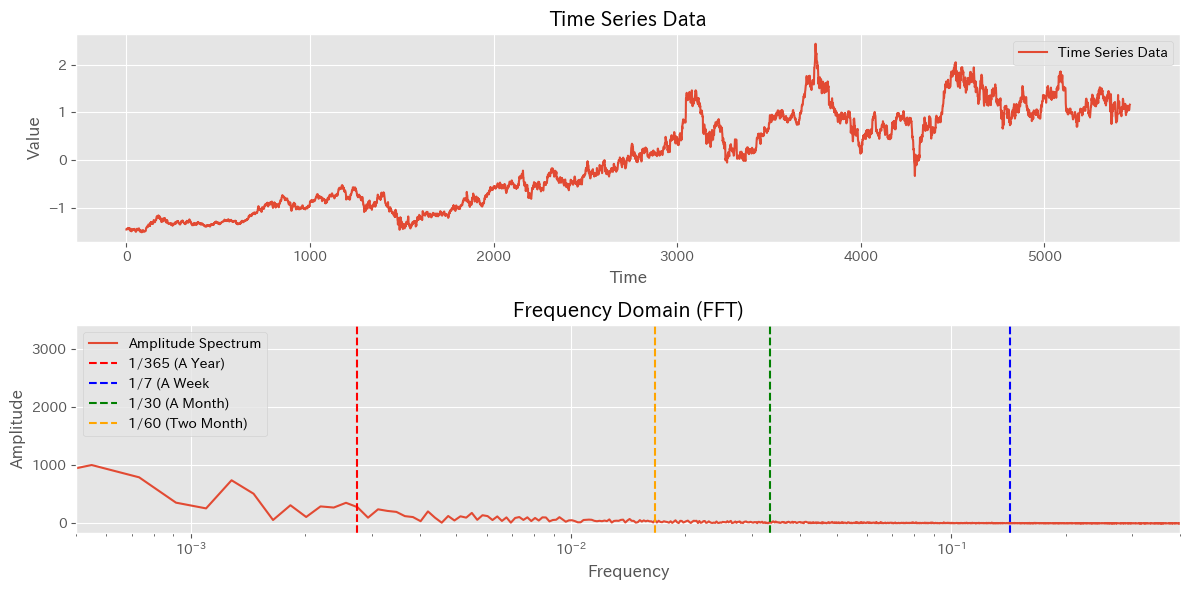

In [ ]:
"""
#seasonal spectrun analysis

data = df["Adj Close"].values
date = np.arange(0, len(data))

fft_result = np.fft.fft(data)  # FFT
frequencies = np.fft.fftfreq(len(data), d=(date[1] - date[0]))  # 周波数

# 振幅（パワースペクトル）を計算
amplitude = np.abs(fft_result)

# 正の周波数部分のみ取得
positive_frequencies = frequencies[frequencies > 0]
positive_amplitude = amplitude[frequencies > 0]

# 可視化
plt.figure(figsize=(12, 6))

# 時系列データのプロット
plt.subplot(2, 1, 1)
plt.plot(date, data, label="Time Series Data")
plt.title("Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

# FFT結果のプロット
plt.subplot(2, 1, 2)
plt.xscale('log')
plt.plot(positive_frequencies, positive_amplitude, label="Amplitude Spectrum")
plt.axvline(x=1/365, color='red', linestyle='--', label="1/365 (A Year)")
plt.axvline(x=1/7, color='blue', linestyle='--', label="1/7 (A Week")
plt.axvline(x=1/30, color='green', linestyle='--', label="1/30 (A Month)")
plt.axvline(x=1/60, color='orange', linestyle='--', label="1/60 (Two Month)")




plt.title("Frequency Domain (FFT)")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

plt.xlim(1/2000, 0.4)

plt.legend()

plt.tight_layout()
plt.show()

"""